In [1]:
# load packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import imageio
from IPython.display import HTML

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchvision.utils import make_grid
import torch.nn.init as init
from torch.utils.data import DataLoader

torch.backends.cudnn.enabled = False
torch.backends.cudnn.benchmark = False

import matplotlib.pyplot as plt

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0' 

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

device = 'cuda' if torch.cuda.is_available() else 'cpu'

import random

random.seed(777)
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [2]:
# Create folders
if not os.path.exists('./checkpoint'):
    os.mkdir('./checkpoint')
    
if not os.path.exists('./dataset'):
    os.mkdir('./dataset')
    
if not os.path.exists('./img'):
    os.mkdir('./img')
    
if not os.path.exists('./img/real'):
    os.mkdir('./img/real')

if not os.path.exists('./img/fake'):
    os.mkdir('./img/fake')

# Load & Define Dataset

In [3]:
batch_size = 1024

fmnist_train = dset.FashionMNIST("./", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
fmnist_test = dset.FashionMNIST("./", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

In [4]:
dataloader = DataLoader(dataset=fmnist_train, batch_size = batch_size, shuffle=True)

In [5]:
sample = next(iter(dataloader))

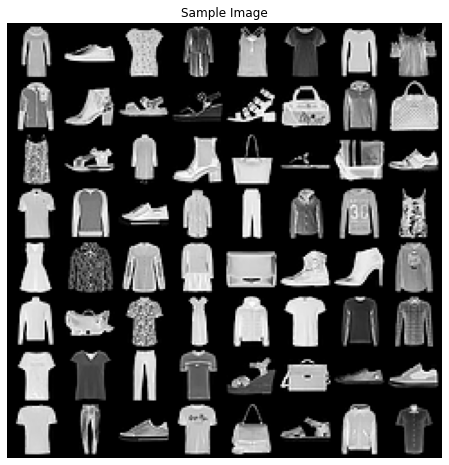

In [6]:
plt.figure(figsize = (8,8))
plt.axis('off')
plt.title('Sample Image')
plt.imshow(np.transpose(vutils.make_grid(sample[0].to(device)[:64,0:1,:,:], padding=2, normalize=True).cpu(),(1,2,0)))

# Modeling

## 1.1 생성망

In [7]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [8]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(

            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 784),
            nn.Sigmoid(),
            
        )

    def forward(self, x) : 
        x = x.view(x.size(0), -1)
        x = self.main(x)
        x = x.view(x.size(0), 1, 28, 28)
        return x

## 1.2 판별망

In [9]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            
            nn.Linear(784, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    def forward(self, x) :
        x = x.view(x.size(0), -1)
        x = self.main(x)
        x = x.squeeze(dim = 1)
        return x
        

In [10]:
netG = Generator().to(device)
netG.apply(weights_init)
optimizerG = optim.Adam(netG.parameters(), lr = 0.0005)


netD = Discriminator().to(device)
netD.apply(weights_init)
optimizerD = optim.Adam(netD.parameters(), lr = 0.0005)

## sample

In [11]:
sampleG = torch.randn((128,100)).to(device)
sampleD = torch.randn((128,1,28,28)).to(device)

g_out = netG(sampleG)
d_out = netD(sampleD)

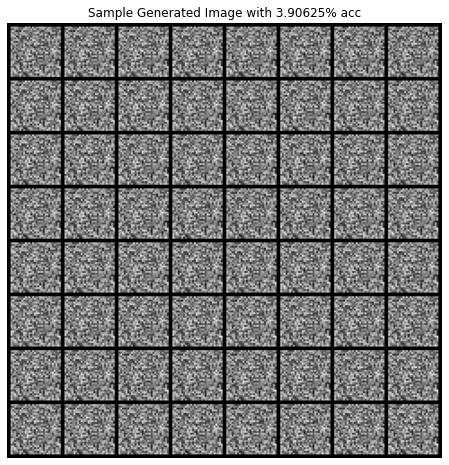

In [12]:
sample_gen_acc = ((d_out > 0.5) == 0).sum().item() / d_out.size(0) * 100
plt.figure(figsize = (8,8))
plt.axis('off')
plt.title(f'Sample Generated Image with {sample_gen_acc}% acc')
plt.imshow(np.transpose(vutils.make_grid(g_out[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

# Training

In [13]:
fixed_noise = torch.randn(batch_size,100).to(device)

In [14]:
criterion = nn.BCELoss()

n_epoch = 200

images = []
for epoch in range(n_epoch) :

    for i, (x, _) in enumerate(dataloader) : 
        netD.zero_grad()

        x = x[:,0:1,:,:].to(device)
        bs = x.size(0)

        true_label = torch.ones((bs,)).to(device) # Discriminator의 정답지
        netD_real = netD(x)
        errD_real = criterion(netD_real, true_label)
        D_x = netD_real.mean().item()

        noise = torch.randn((bs,100)).to(device)
        fake_x = netG(noise)
        false_label = torch.zeros((bs,)).to(device)
        netD_fake = netD(fake_x.detach())
        errD_fake = criterion(netD_fake, false_label)
        D_G_z1 = netD_fake.mean().item()

        errD = errD_real + errD_fake
        errD.backward()
        optimizerD.step()

        netG.zero_grad()
        gen_label = torch.ones((bs, )).to(device)
        gen_out = netD(fake_x)
        errG = criterion(gen_out, gen_label)
        D_G_z2 = gen_out.mean().item()

        errG.backward()
        optimizerG.step()
    print(f'[{epoch} / {n_epoch}] Loss_D : {round(errD.item(),4)}, Loss_G : {round(errG.item(), 4)} // D(x) : {D_x}, D(G(z)) : {D_G_z1/D_G_z2}')

    fake = netG(fixed_noise)
    images.append(fake)

    torch.save(netG.state_dict(), './checkpoint/netG_epoch_%d.pth' % (epoch))
    torch.save(netD.state_dict(), './checkpoint/netD_epoch_%d.pth' % (epoch))

    # if D_x > 0.7 : 
    #     break;

[0 / 200] Loss_D : 0.3332, Loss_G : 3.5451 // D(x) : 0.8435088992118835, D(G(z)) : 3.7057792623681736
[1 / 200] Loss_D : 0.0291, Loss_G : 9.4818 // D(x) : 0.9821506142616272, D(G(z)) : 33.416385633545154
[2 / 200] Loss_D : 0.025, Loss_G : 9.2757 // D(x) : 0.9904587268829346, D(G(z)) : 9.435382690093858
[3 / 200] Loss_D : 0.1768, Loss_G : 6.1468 // D(x) : 0.9272680878639221, D(G(z)) : 3.661973607743015
[4 / 200] Loss_D : 0.0145, Loss_G : 7.2361 // D(x) : 0.9916804432868958, D(G(z)) : 2.5785651597201493
[5 / 200] Loss_D : 0.1679, Loss_G : 6.6116 // D(x) : 0.9310898184776306, D(G(z)) : 6.0540162942813085
[6 / 200] Loss_D : 0.0092, Loss_G : 6.8126 // D(x) : 0.9966132640838623, D(G(z)) : 4.349972083149665
[7 / 200] Loss_D : 0.0084, Loss_G : 7.0704 // D(x) : 0.9992467164993286, D(G(z)) : 2.5491852231713903
[8 / 200] Loss_D : 0.3712, Loss_G : 4.519 // D(x) : 0.9306527376174927, D(G(z)) : 4.720308069009859
[9 / 200] Loss_D : 0.2106, Loss_G : 3.9675 // D(x) : 0.9556812644004822, D(G(z)) : 2.533

# Load & Generate Images

pip install celluloid

In [15]:
from glob import glob
import matplotlib.pyplot as plt

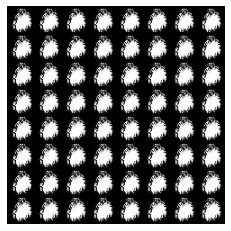

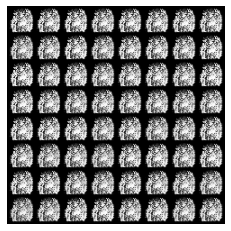

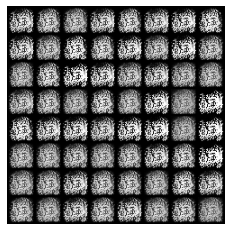

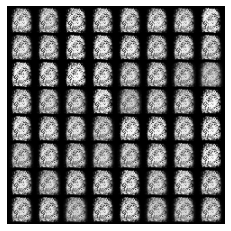

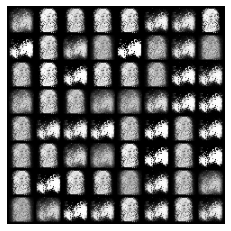

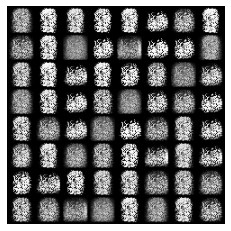

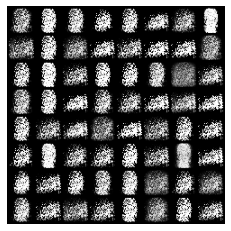

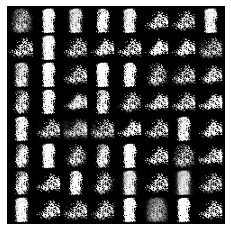

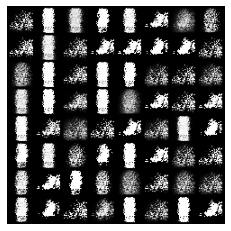

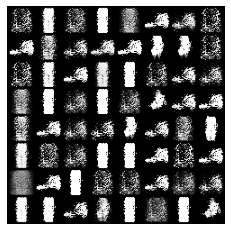

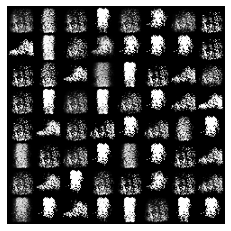

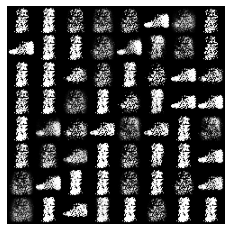

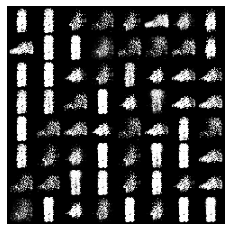

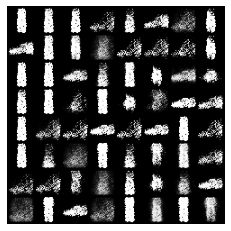

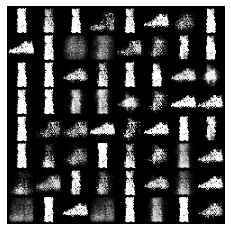

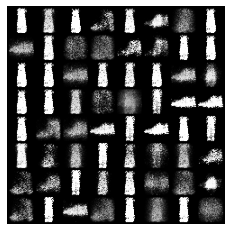

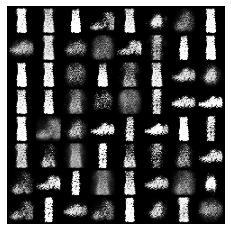

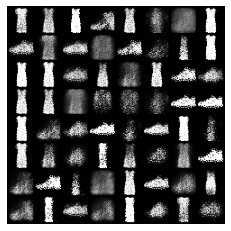

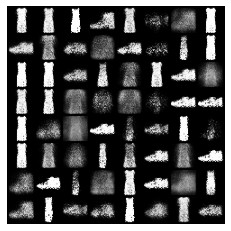

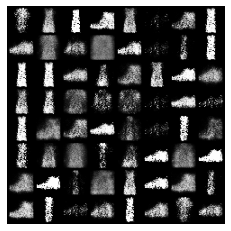

In [17]:
model_paths = glob('./checkpoint/netG*')
model_paths = sorted(model_paths, key = lambda x : int(x.split('_')[-1].replace('.pth','')))
images = []
for path in model_paths[::10] : 
    netG.load_state_dict(torch.load(path))
    image = netG(fixed_noise)[:64]
    image = vutils.make_grid(image, padding=2, normalize=True).cpu()
    plt.imshow(np.transpose(image, (1,2,0)))
    plt.axis('off')
    plt.show()